**Script overview**:

This script computes engine degradation curves over aircraft lifetime. It does so using data from Mr. Urs Glarner, Sr. Field Representative at the Customer Service of Pratt & Whitney/ IAE International Aero Engines.

The average engine degradation of all aircraft types present in the global flight schedules from OAG in 2018 is calculated using the average age for each aircraft type from the aircraft fleet data from Planespotters.

# Load packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load and preprocess data

**Load engine degradation data from preprocessed sheet, compiled based on input by Urs Glarner:**
efficiency losses in percent

In [2]:
raw = pd.read_excel('datasets/aircraft_engine_degradation_manual.xlsx',sheet_name='overhaul_and_engine_wash')

In [3]:
flight_hours_per_year = pd.DataFrame(raw.loc[4,['Unnamed: 9', 'Unnamed: 10']].copy()).T.reset_index(drop=True)
flight_hours_per_year = flight_hours_per_year.rename(columns={'Unnamed: 9': 'medium_haul', 'Unnamed: 10': 'long_haul'})
flight_hours_per_year

,medium_haul,long_haul
0,2600,5200


In [4]:
medium_haul = raw.loc[39:,['Unnamed: 3', 'Unnamed: 7']].copy()
medium_haul = medium_haul.rename(columns={'Unnamed: 3': 'flight_hours', 'Unnamed: 7': 'efficiency_loss'}).reset_index(drop=True)
medium_haul['years'] = medium_haul['flight_hours']/flight_hours_per_year.loc[0,'medium_haul']
medium_haul = medium_haul.drop(columns='flight_hours')
medium_haul.head()

,efficiency_loss,years
0,0,0
1,-0.07523,0.0384615
2,-0.15046,0.0769231
3,-0.22569,0.115385
4,-0.30092,0.153846


In [5]:
long_haul = raw.loc[39:,['Unnamed: 11', 'Unnamed: 15']].copy()
long_haul = long_haul.rename(columns={'Unnamed: 11': 'flight_hours', 'Unnamed: 15': 'efficiency_loss'}).reset_index(drop=True)
long_haul['years'] = long_haul['flight_hours']/flight_hours_per_year.loc[0,'long_haul']
long_haul = long_haul.drop(columns='flight_hours')
long_haul.head()

,efficiency_loss,years
0,0,0
1,-0.0869733,0.0384615
2,-0.173947,0.0769231
3,-0.26092,0.115385
4,-0.347893,0.153846


# Fitting

In [6]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def func(x, a):
    return -a*np.log(x+1)

## medium haul

In [7]:
popt_medium, pcov = curve_fit(func, np.array(medium_haul['years'],dtype=np.float), np.array(medium_haul['efficiency_loss'],dtype=np.float))
popt_medium

array([1.28188286])

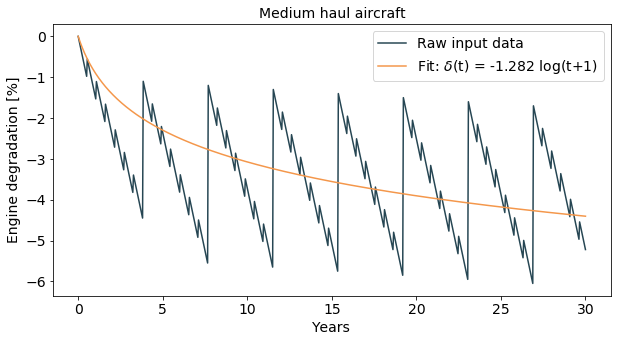

In [8]:
plt.figure(figsize=(10,5))
plt.plot(medium_haul['years'], medium_haul['efficiency_loss'], label='Raw input data', color='#264653')
plt.plot(np.array(medium_haul['years'],dtype=np.float), func(np.array(medium_haul['years'],dtype=np.float), popt_medium), 'r-', label='Fit: $\delta$(t) = -%5.3f log(t+1)' % popt_medium, color='#f4974b')
plt.title('Medium haul aircraft', fontsize=14)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Engine degradation [%]', fontsize=14)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.savefig('gfx/Engine_degrad_medium.png', dpi=500)


## long haul

In [9]:
popt_long, pcov = curve_fit(func, np.array(long_haul['years'],dtype=np.float), np.array(long_haul['efficiency_loss'],dtype=np.float))
popt_long

array([1.33837184])

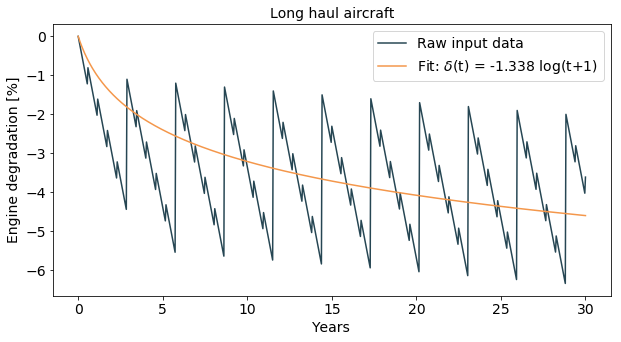

In [10]:
plt.figure(figsize=(10,5))
plt.plot(long_haul['years'], long_haul['efficiency_loss'], label='Raw input data', color='#264653')
plt.plot(np.array(long_haul['years'],dtype=np.float), func(np.array(long_haul['years'],dtype=np.float), popt_long), 'r-', label='Fit: $\delta$(t) = -%5.3f log(t+1)' % popt_long, color='#f4974b')
plt.title('Long haul aircraft', fontsize=14)
plt.xlabel('Years', fontsize=14)
plt.ylabel('Engine degradation [%]', fontsize=14)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.savefig('gfx/Engine_degrad_long.png', dpi=500)

# Average engine degradation factor for fleet

## Load 2018 OAG data to distinguish between medium and long haul

In [11]:
# Connect to DB
%load_ext ipython_pg.LAV
%run pg_password.ipynb
%pg_connect dbname='mobility' host='lav-fileserver.ethz.ch' user='heldm'

Enter password:········
password for heldm@lav-fileserver.ethz.ch:5433:········
SUCCESS: connected to lav-fileserver.ethz.ch
  PostGIS integration enabled

In [12]:
%%pg_pd oag18
SELECT * FROM "OAG"."2018_schedule_ps_conform"

SUCCES: matched 191618 rows
 results stored as 'oag18'


In [13]:
oag18 = oag18.rename(columns={'frequency_2018': 'frequency', 'fkm_2018': 'fkm'})

In [14]:
def wavg(dta):
    """ Takes data with at least two columns (gc_distance and frequency) and returns the weighted average.
    """
    try:
        return (dta.gc_distance * dta.frequency).sum() / dta.frequency.sum()
    except ZeroDivisionError:
        return dta.gc_distance.mean()

In [15]:
oag18_trip_len = pd.DataFrame(oag18.groupby('ac_code_iata').apply(wavg))
oag18_trip_len = oag18_trip_len.rename(columns={0:'gc_distance'}).sort_values(by='gc_distance').reset_index()
oag18_trip_len.head()

,ac_code_iata,gc_distance
0,CN2,45.932968
1,DHP,55.571411
2,PA1,57.694043
3,BNI,61.411922
4,CNT,98.665807


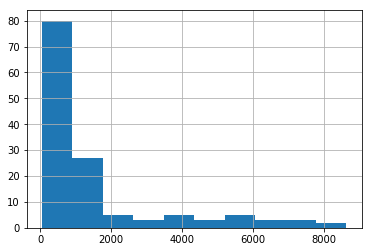

In [16]:
oag18_trip_len.gc_distance.hist()

**We separate the data set into medium and long haul flights at an average gc_distance flewn in 2018 of 4000km.**

In [17]:
ac_medium_haul = np.array(oag18_trip_len.loc[oag18_trip_len[oag18_trip_len.gc_distance < 4000].index, 'ac_code_iata'])
ac_medium_haul

array(['CN2', 'DHP', 'PA1', 'BNI', 'CNT', 'DHL', 'PAG', 'PA2', 'CNA',
       'DHT', 'D28', 'CNF', 'DH7', 'YN2', 'CNJ', 'DHC', 'EMB', 'J41',
       'J32', 'BE1', 'SWM', 'DH2', 'DH1', 'SF3', 'MA6', 'J31', 'AT7',
       'EM2', 'AT4', 'DH3', 'PL2', 'ATP', 'BEC', 'F50', 'DHD', 'D38',
       'DH4', '142', 'BE2', 'AR1', 'YK4', 'CR1', 'A38', '141', 'FRJ',
       'S20', '143', 'F70', 'A40', 'AR8', 'CRK', 'CV5', 'BE4', 'M81',
       'ER4', 'CS1', 'ER3', 'F28', 'CR7', '318', 'CR2', 'M87', 'CR9',
       'E95', 'E70', 'AN4', '722', '717', 'AN6', 'EP3', 'C27', 'M82',
       'M83', '100', 'M88', 'GJ5', '735', '290', 'DC9', 'E75', 'CS3',
       'A58', 'GRJ', '736', '733', 'TU3', 'SU9', 'E7W', '73G', '734',
       '319', 'M90', 'YK2', 'A81', '320', 'A32', '32N', 'CJ8', '73L',
       '32Q', '738', '321', 'AB4', 'T20', 'L4T', '739', '7M9', '313',
       '7M8', 'AB6', '753', '762', 'TU5', '752', '333', '763', '781'],
      dtype=object)

In [18]:
ac_long_haul = np.array(oag18_trip_len.loc[oag18_trip_len[oag18_trip_len.gc_distance >= 4000].index, 'ac_code_iata'])
ac_long_haul

array(['764', '351', '332', '772', '773', '788', '359', '77W', '744',
       '789', 'IL9', '343', '77L', '346', '388', '342', '74H', '339',
       '345'], dtype=object)

## Load Planespotters data

In [19]:
%%pg_pd ps
SELECT * FROM "Planespotters"."pax_fleet_2018_12_31"

SUCCES: matched 28411 rows
 results stored as 'ps'


**Change Planspotters ac name to IATA code**

In [20]:
ps = ps.rename(columns={'ac_type':'ac_name_ps'})

In [21]:
ac_type_designators = pd.read_csv('datasets/aircraft_type_designators.csv',index_col=0)
ac_type_designators

,ac_code_iata,ac_code_icao,ac_name_oag,ac_name_ps,widebody,narrowbody
0,CS1,BCS1,Airbus A220-100,Airbus A220-100,NaN,x
1,CS3,BCS3,Airbus A220-300,Airbus A220-300,NaN,x
2,AB6,A306,Airbus A300-600 Passenger,Airbus A300-600,x,NaN
3,AB4,A30B,Airbus A300B2/B4 Passenger,Airbus A300B4,x,NaN
4,313,A310,Airbus A310-300 Passenger,Airbus A310-300,x,NaN
5,318,A318,Airbus A318,Airbus A318-100,NaN,x
6,319,A319,Airbus A319,Airbus A319-100,NaN,x
7,320,A320,Airbus A320 (with and without Sharklets),Airbus A320-200,NaN,x
8,32N,A20N,Airbus A320neo,Airbus A320neo,NaN,x
9,321,A321,Airbus A321 (with and without Sharklets),Airbus A321-200,NaN,x


In [22]:
iata_to_ps_AC_lookup = ac_type_designators.set_index('ac_name_ps').to_dict()['ac_code_iata']
ps['ac_code_iata'] = ps['ac_name_ps'].replace(iata_to_ps_AC_lookup)

**Compute average age for each aircraft type**

In [23]:
engine_degrad = pd.DataFrame(ps.groupby('ac_code_iata').mean().age).reset_index()
engine_degrad = engine_degrad.rename(columns={'age':'average_age_2018'})
engine_degrad.head()

,ac_code_iata,average_age_2018
0,100,26.406875
1,141,30.720000
2,142,30.555556
3,143,27.989286
4,290,8.260681


## Apply medium- and long-haul degradation factors to fleet

In [24]:
for i in engine_degrad.index:
    if engine_degrad.ac_code_iata[i] in ac_long_haul:
        engine_degrad.at[i,'engine_degrad'] = func(engine_degrad.average_age_2018[i], popt_long)
    elif engine_degrad.ac_code_iata[i] in ac_medium_haul:
        engine_degrad.at[i,'engine_degrad'] = func(engine_degrad.average_age_2018[i], popt_medium)
    else:
        print('Error: ', engine_degrad.ac_code_iata[i])

In [25]:
engine_degrad.ac_code_iata.astype(str)
engine_degrad

,ac_code_iata,average_age_2018,engine_degrad
0,100,26.406875,-4.244050
1,141,30.720000,-4.431402
2,142,30.555556,-4.424739
3,143,27.989286,-4.316005
4,290,8.260681,-2.853186
5,313,28.222222,-4.326264
6,318,12.394000,-3.326238
7,319,13.394242,-3.418561
8,320,9.715740,-3.040259
9,321,7.211504,-2.699051


In [26]:
engine_degrad.to_csv('datasets/aircraft_engine_degradation.csv')

In [27]:
engine_degrad_full = pd.read_csv('datasets/aircraft_type_designators_full.csv',index_col=0)
engine_degrad_full = engine_degrad_full.merge(engine_degrad,how='left',on='ac_code_iata')
engine_degrad_full.loc[engine_degrad_full.engine_degrad.isna(),'engine_degrad'] = engine_degrad.engine_degrad.mean()
engine_degrad_full

,ac_code_iata,ac_code_icao,ac_name_oag,ac_type,average_age_2018,engine_degrad
0,A40,A140,Antonov AN-140,narrowbody,13.900000,-3.462829
1,A81,A148,Antonov An148-100,narrowbody,8.028571,-2.820648
2,A58,A158,Antonov An-158,narrowbody,6.128571,-2.517760
3,32N,A20N,Airbus A320neo,narrowbody,0.953373,-0.858294
4,32Q,A21N,Airbus A321neo,narrowbody,0.514050,-0.531710
5,AB6,A306,Airbus A300-600 Passenger,widebody,26.942105,-4.268843
6,AB4,A30B,Airbus A300B2/B4 Passenger,widebody,37.187500,-4.669269
7,313,A310,Airbus A310-300 Passenger,widebody,28.222222,-4.326264
8,318,A318,Airbus A318,narrowbody,12.394000,-3.326238
9,319,A319,Airbus A319,narrowbody,13.394242,-3.418561


In [28]:
engine_degrad_full.to_csv('datasets/aircraft_engine_degradation_full.csv')